# Stock Price Prediction Using Machine Learning

## Importing libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import tensorflow as tf
import time as tm
import datetime as dt
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

## Setting template

In [3]:
pio.templates.default = "plotly_dark"

In [4]:
N_STEPS = 7
LOOKUP_STEPS = [1,2,3]

In [5]:
current_date = tm.strftime('%Y-%m-%d')

## Loading Data

In [6]:
stock_data = yf.Ticker("^SET.BK")
STOCK = '^SET.BK'

In [7]:
print(stock_data.info)

{'maxAge': 86400, 'priceHint': 2, 'previousClose': 1377.93, 'open': 1384.84, 'dayLow': 1378.28, 'dayHigh': 1389.26, 'regularMarketPreviousClose': 1377.93, 'regularMarketOpen': 1384.84, 'regularMarketDayLow': 1378.28, 'regularMarketDayHigh': 1389.26, 'averageVolume': 4429941, 'averageVolume10days': 3297850, 'averageDailyVolume10Day': 3297850, 'fiftyTwoWeekLow': 1378.28, 'fiftyTwoWeekHigh': 1695.99, 'fiftyDayAverage': 1592.2676, 'twoHundredDayAverage': 1617.0726, 'currency': 'THB', 'exchange': 'SET', 'quoteType': 'INDEX', 'symbol': '^SET.BK', 'underlyingSymbol': '^SET.BK', 'shortName': 'SET_SET Index', 'longName': 'SET Index', 'firstTradeDateEpochUtc': 850273200, 'timeZoneFullName': 'Asia/Bangkok', 'timeZoneShortName': 'ICT', 'uuid': 'fc910598-603b-3e4f-a070-7a2580966424', 'messageBoardId': 'finmb_INDEXSET.BK', 'gmtOffSetMilliseconds': 25200000, 'trailingPegRatio': None}


In [8]:
for key, value in stock_data.info.items() :
  print(key , ":" , value)

maxAge : 86400
priceHint : 2
previousClose : 1377.93
open : 1384.84
dayLow : 1378.28
dayHigh : 1389.26
regularMarketPreviousClose : 1377.93
regularMarketOpen : 1384.84
regularMarketDayLow : 1378.28
regularMarketDayHigh : 1389.26
averageVolume : 4429941
averageVolume10days : 3297850
averageDailyVolume10Day : 3297850
fiftyTwoWeekLow : 1378.28
fiftyTwoWeekHigh : 1695.99
fiftyDayAverage : 1592.2676
twoHundredDayAverage : 1617.0726
currency : THB
exchange : SET
quoteType : INDEX
symbol : ^SET.BK
underlyingSymbol : ^SET.BK
shortName : SET_SET Index
longName : SET Index
firstTradeDateEpochUtc : 850273200
timeZoneFullName : Asia/Bangkok
timeZoneShortName : ICT
uuid : fc910598-603b-3e4f-a070-7a2580966424
messageBoardId : finmb_INDEXSET.BK
gmtOffSetMilliseconds : 25200000
trailingPegRatio : None


In [9]:
stock_data.history(period="1y")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-19 00:00:00+07:00,1682.130005,1690.689941,1681.719971,1688.479980,4050400,0.0,0.0
2023-01-20 00:00:00+07:00,1687.420044,1688.589966,1672.489990,1677.250000,5394100,0.0,0.0
2023-01-23 00:00:00+07:00,1681.329956,1689.520020,1677.520020,1684.040039,4418700,0.0,0.0
2023-01-24 00:00:00+07:00,1689.900024,1693.969971,1682.579956,1682.939941,4043600,0.0,0.0
2023-01-25 00:00:00+07:00,1686.130005,1687.510010,1678.709961,1682.109985,4597000,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-15 00:00:00+07:00,1415.630005,1416.010010,1404.810059,1407.020020,12756400,0.0,0.0
2024-01-16 00:00:00+07:00,1406.109985,1407.079956,1399.849976,1401.719971,3165100,0.0,0.0
2024-01-17 00:00:00+07:00,1397.640015,1397.969971,1378.849976,1380.650024,4182700,0.0,0.0


**yfinance** returns a **pandas.DataFrame** with multi-level column names, with a level for the ticker and a level for the stock price data

In [10]:
yf.pdr_override()

In [11]:
stock_data = pdr.get_data_yahoo({STOCK}, start='2023-01-21', end='2024-01-21') #Change the date

[*********************100%%**********************]  1 of 1 completed


In [12]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-23,1681.329956,1689.520020,1677.520020,1684.040039,1684.040039,4418700
2023-01-24,1689.900024,1693.969971,1682.579956,1682.939941,1682.939941,4043600
2023-01-25,1686.130005,1687.510010,1678.709961,1682.109985,1682.109985,4597000
2023-01-26,1682.800049,1684.839966,1667.430054,1671.339966,1671.339966,5208700
2023-01-27,1674.410034,1683.770020,1670.910034,1681.300049,1681.300049,4194700
...,...,...,...,...,...,...
2024-01-15,1415.630005,1416.010010,1404.810059,1407.020020,1407.020020,12756400
2024-01-16,1406.109985,1407.079956,1399.849976,1401.719971,1401.719971,3165100
2024-01-17,1397.640015,1397.969971,1378.849976,1380.650024,1380.650024,4182700


Assign the index of a DataFrame to a column named 'Date'

In [13]:
stock_data['Date'] = stock_data.index

## Displaying the basic information about dataset.

In [14]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2023-01-23 to 2024-01-19
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       241 non-null    float64       
 1   High       241 non-null    float64       
 2   Low        241 non-null    float64       
 3   Close      241 non-null    float64       
 4   Adj Close  241 non-null    float64       
 5   Volume     241 non-null    int64         
 6   Date       241 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 15.1 KB


In [15]:
stock_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,241.0,1.519290e+03,8.630135e+01,1369.880005,1.431880e+03,1.531300e+03,1.566000e+03,1.689900e+03
High,241.0,1.525368e+03,8.606510e+01,1370.390015,1.438100e+03,1.536760e+03,1.572430e+03,1.693970e+03
Low,241.0,1.510231e+03,8.630793e+01,1354.729980,1.425400e+03,1.521180e+03,1.559340e+03,1.682580e+03
Close,241.0,1.517208e+03,8.617171e+01,1357.969971,1.431720e+03,1.529120e+03,1.565000e+03,1.688360e+03
Adj Close,241.0,1.517208e+03,8.617171e+01,1357.969971,1.431720e+03,1.529120e+03,1.565000e+03,1.688360e+03
Volume,241.0,4.137095e+06,1.880888e+06,0.000000,3.172600e+06,3.704100e+06,4.396800e+06,1.629810e+07


## Checking Missing Data

In [16]:
stock_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Date         0
dtype: int64

## Checking Outliers

In [17]:
fig = go.Figure()

fig.add_trace(go.Box(y=stock_data['Adj Close'], quartilemethod="linear", name="Adjust Close"))
fig.add_trace(go.Box(y=stock_data['Close'], quartilemethod="linear", name="Close"))
fig.add_trace(go.Box(y=stock_data['Open'], quartilemethod="linear", name="Open"))
fig.add_trace(go.Box(y=stock_data['High'], quartilemethod="linear", name="High"))
fig.add_trace(go.Box(y=stock_data['Low'], quartilemethod="linear", name="Low"))

fig.update_layout(title='Potential outliers in stock price data.')
fig.update_traces(boxpoints='all', jitter=0)
fig.show()

In [18]:
stock_data.corr()

<ipython-input-18-4a552a2330cf>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998009,0.997162,0.993826,0.993826,0.211861
High,0.998009,1.000000,0.997568,0.997257,0.997257,0.213927
Low,0.997162,0.997568,1.000000,0.997702,0.997702,0.205774
Close,0.993826,0.997257,0.997702,1.000000,1.000000,0.202984
Adj Close,0.993826,0.997257,0.997702,1.000000,1.000000,0.202984
Volume,0.211861,0.213927,0.205774,0.202984,0.202984,1.000000


## Data Visualization

In [19]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['Close'], mode='lines', name='Close'))
fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['Adj Close'], mode='lines', name='Adjusted Close'))
fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['High'], mode='lines', name='High'))
fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['Low'], mode='lines', name='Low'))
fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['Open'], mode='lines', name='Open'))

fig.update_layout(title='The Historical Prices', showlegend=True, height=400, yaxis_title='Price', xaxis_title='Date')
fig.show()

I just need one column ‘close’ which is the price on the closing market on the particular day.

In [20]:
stock_data.drop(['Open', 'High', 'Low','Volume', 'Adj Close'], axis=1).round(3)

,Close,Date
Date,,
2023-01-23,1684.04,2023-01-23
2023-01-24,1682.94,2023-01-24
2023-01-25,1682.11,2023-01-25
2023-01-26,1671.34,2023-01-26
2023-01-27,1681.30,2023-01-27
...,...,...
2024-01-15,1407.02,2024-01-15
2024-01-16,1401.72,2024-01-16
2024-01-17,1380.65,2024-01-17


Plot to show the graphic of 'Close' and 'Date'

In [21]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['Close'], mode='lines', name='Close Price'))

fig1.update_layout(title= 'Close Prices', showlegend=True, xaxis_title='Date', yaxis_title='Price', height=400)

fig1.show()

## Scale Data

Snippet performs feature scaling on the 'Close' prices in the **stock_data**, making them suitable for machine learning models that benefit from having input features on a similar scale.

In [22]:
scaler = MinMaxScaler()

In [23]:
stock_data['Scaled_Close'] = scaler.fit_transform(np.expand_dims(stock_data['Close'].values, axis=1))


We see the price scaled in the range between 0 and 1.

In [24]:
stock_data['Scaled_Close']

Date
2023-01-23    0.986925
2023-01-24    0.983595
2023-01-25    0.981083
2023-01-26    0.948485
2023-01-27    0.978632
                ...   
2024-01-15    0.148461
2024-01-16    0.132419
2024-01-17    0.068646
2024-01-18    0.060414
2024-01-19    0.074276
Name: Scaled_Close, Length: 241, dtype: float64

In [25]:
def PrepareData(days):
    data = stock_data.copy() #Creates a copy of a DataFrame
    data['Future'] = data['Scaled_Close'].shift(-days) #Adds a new column named 'Future' to the DataFrame by shifting the 'Scaled_Close' column upward by days positions.
    last_sequence = np.array(data[['Scaled_Close']].tail(days)) #This will be used as a sequence for predicting the future values.
    data.dropna(inplace=True) #Removes any rows with missing values (NaN) in the DataFrame.
    sequence_data = [] #Initializes an empty list to store sequences of input features and their corresponding target values.
    sequence = deque(maxlen=N_STEPS) #This deque will be used to keep track of a sliding window of input features.

    for entry, target in zip(data[['Scaled_Close'] + ['Date']].values, data['Future'].values):
        sequence.append(entry)
        if len(sequence) == N_STEPS:
            sequence_data.append([np.array(sequence), target])

    last_sequence = list([s[:len(['Scaled_Close'])] for s in sequence]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    X, Y = [], [] # Initializes empty lists to store input sequences (X) and target values (Y).
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)

    X = np.array(X)
    Y = np.array(Y)

    return data, last_sequence, X, Y #These can be used for training a machine learning model for time series prediction.


In [26]:
PrepareData(3)

(                   Open         High          Low        Close    Adj Close  \
 Date                                                                          
 2023-01-23  1681.329956  1689.520020  1677.520020  1684.040039  1684.040039   
 2023-01-24  1689.900024  1693.969971  1682.579956  1682.939941  1682.939941   
 2023-01-25  1686.130005  1687.510010  1678.709961  1682.109985  1682.109985   
 2023-01-26  1682.800049  1684.839966  1667.430054  1671.339966  1671.339966   
 2023-01-27  1674.410034  1683.770020  1670.910034  1681.300049  1681.300049   
 ...                 ...          ...          ...          ...          ...   
 2024-01-10  1416.030029  1418.329956  1410.209961  1413.520020  1413.520020   
 2024-01-11  1417.300049  1417.640015  1407.260010  1408.239990  1408.239990   
 2024-01-12  1407.949951  1416.329956  1407.770020  1413.530029  1413.530029   
 2024-01-15  1415.630005  1416.010010  1404.810059  1407.020020  1407.020020   
 2024-01-16  1406.109985  1407.079956  1

In [27]:
def GetTrainedModel(X_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['Scaled_Close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='Adam')

  model.fit(X_train, y_train,
            batch_size=12,
            epochs=100,
            verbose=1)

  model.summary()

  return model

## Get Predictions

In [28]:
Predictions = [] #This initializes an empty list called Predictions where we will store the predicted prices.

for step in LOOKUP_STEPS: #Loop through LOOKUP_STEPS
  df, last_sequence, X_train, y_train = PrepareData(step)
  X_train = X_train[:, :, :len(['Scaled_Close'])].astype(np.float32) # Adjusts the data type of X_train to float32.

  model = GetTrainedModel(X_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  Predictions.append(round(float(predicted_price), 3))

Epoch 1/100
20/20 [==============================] - 6s 14ms/step - loss: 0.0600
Epoch 2/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0114
Epoch 3/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0073
Epoch 4/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0058
Epoch 5/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0063
Epoch 6/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0075
Epoch 7/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0077
Epoch 8/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0058
Epoch 9/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0059
Epoch 10/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0047
Epoch 11/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0055
Epoch 12/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0064
Epoch 13/100
20/20 [=====

In [29]:
if bool(Predictions) == True and len(Predictions) > 0:
  prediction_list = ['$'+str(d) for d in Predictions]
  prediction_str = ', '.join(prediction_list)
  message = f'Stock prices prediction for upcoming in 3 days is ({prediction_str})'

  print(message)

Stock prices prediction for upcoming in 3 days is ($1385.994, $1379.43, $1385.898)


In [30]:
copy_df = stock_data.copy()
y_predicted = model.predict(X_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

8/8 [==============================] - 0s 6ms/step


In [31]:
copy_df.drop(['Open', 'High', 'Low','Volume', 'Adj Close'], axis=1).round(3)

,Close,Date,Scaled_Close,predicted_close
Date,,,,
2023-01-23,1684.04,2023-01-23,0.987,1688.360
2023-01-24,1682.94,2023-01-24,0.984,1682.110
2023-01-25,1682.11,2023-01-25,0.981,1680.490
2023-01-26,1671.34,2023-01-26,0.948,1670.340
2023-01-27,1681.30,2023-01-27,0.979,1669.170
...,...,...,...,...
2024-01-15,1407.02,2024-01-15,0.148,1411.891
2024-01-16,1401.72,2024-01-16,0.132,1408.278
2024-01-17,1380.65,2024-01-17,0.069,1380.650


In [32]:
current_date = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[current_date, ['Close', 'Date', 'Volume', 'predicted_close']] = [Predictions[0], f'{current_date}', 0, 0]
copy_df.loc[date_tomorrow, ['Close', 'Date', 'Volume', 'predicted_close']] = [Predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow, ['Close', 'Date', 'Volume', 'predicted_close']] = [Predictions[2], f'{date_after_tomorrow}', 0, 0]


<ipython-input-32-5a7f3f5a1b49>:5: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

<ipython-input-32-5a7f3f5a1b49>:6: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

<ipython-input-32-5a7f3f5a1b49>:7: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



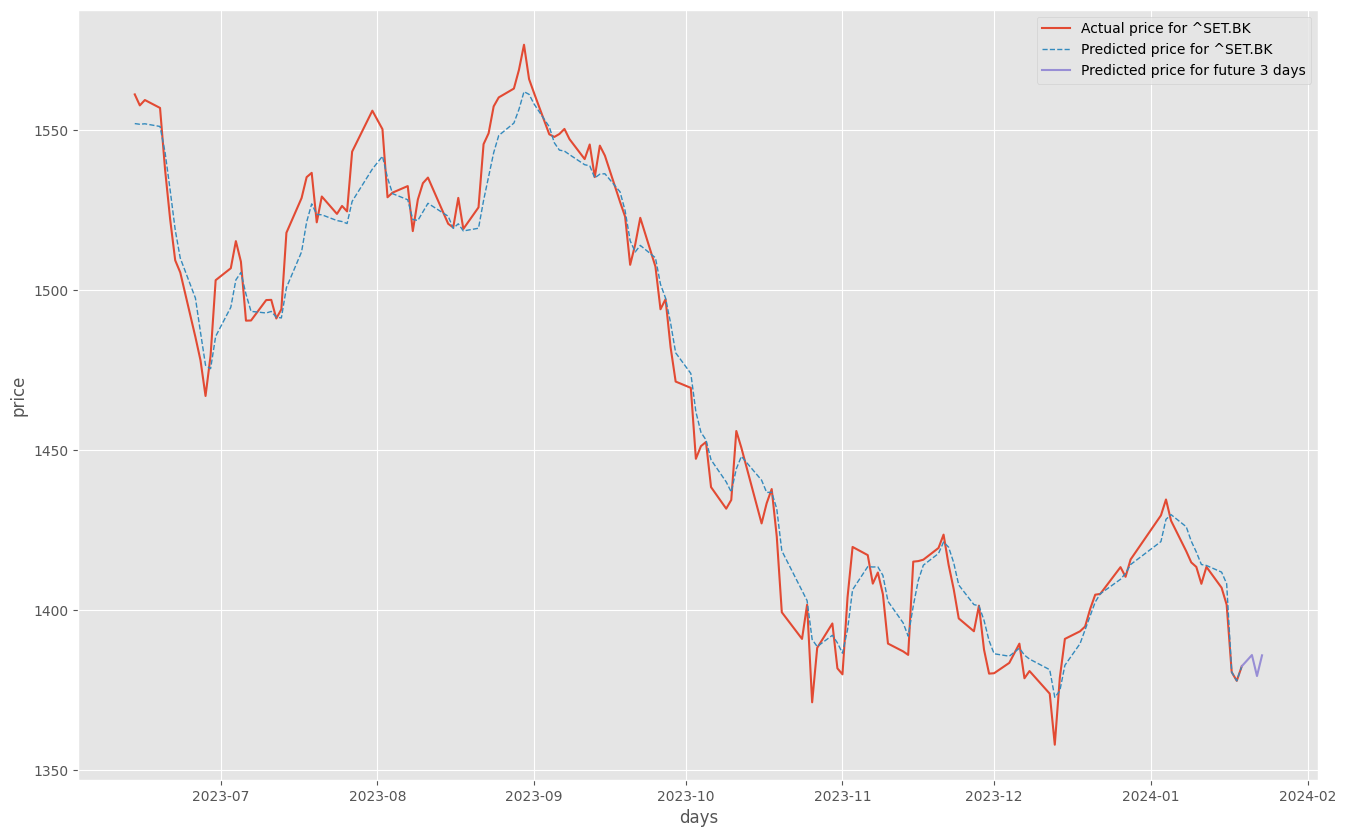

In [33]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['Close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['Close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

In [34]:
print(prediction_str)

$1385.994, $1379.43, $1385.898
